In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
from gnninterpreter import *

In [8]:
import torch

# Motif

In [9]:
dataset = MotifDataset(seed=12345)

data: Data(x=[20, 5], edge_index=[2, 52], y=[1], G=Graph named 'House Graph' with 20 nodes and 26 edges)
class: house


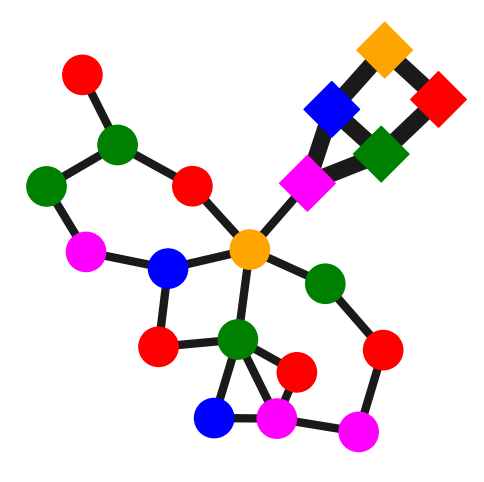

In [10]:
dataset.show(0)

In [28]:
model = GCNClassifier(node_features=len(dataset.NODE_CLS),
                      num_classes=len(dataset.GRAPH_CLS),
                      hidden_channels=64,
                      num_layers=3)
model.load_state_dict(torch.load('ckpts/motif_bkup.pt'))

<All keys matched successfully>

In [29]:
dataset_list_gt = dataset.split_by_class()
dataset_list_pred = dataset.split_by_pred(model)

/opt/homebrew/Caskroom/mambaforge/base/envs/gnninterpreter/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. The data of the dataset is already cached, so any modifications to `data` will not be reflected when accessing its elements. Clearing the cache now by removing all elements in `dataset._data_list`. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
/opt/homebrew/Caskroom/mambaforge/base/envs/gnninterpreter/lib/python3.10/site-packages/torch_geometric/data/in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you ar

In [30]:
evaluation = dataset.model_evaluate(model)
evaluation

{'acc': 0.9966177940368652,
 'cm': array([[2270,   16,    4,   13,    0],
        [   2, 2211,    0,    0,    0],
        [   1,    0, 2270,    0,    0],
        [   3,    0,    0, 2401,    0],
        [   0,    0,    0,    0, 2340]]),
 'f1': {'partial': 0.9914828538894653,
  'house': 0.995945930480957,
  'house_x': 0.9988998770713806,
  'comp_4': 0.9966791272163391,
  'comp_5': 1.0}}

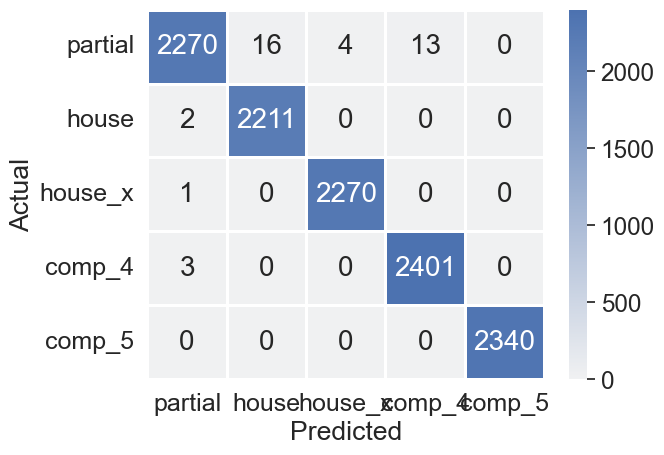

In [31]:
draw_matrix(evaluation['cm'], dataset.GRAPH_CLS.values(), fmt='d')

In [32]:
mean_embeds = [d.model_transform(model, key="embeds").mean(dim=0) for d in dataset_list_gt]

/opt/homebrew/Caskroom/mambaforge/base/envs/gnninterpreter/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [33]:
trainer = {}
sampler = {}

# House

In [64]:
cls_idx = 1
trainer[cls_idx] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=25,
        num_node_cls=len(dataset.NODE_CLS),
        temperature=0.2,
        learn_node_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=cls_idx, mode='maximize'), weight=5),
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=0, mode='minimize'), weight=5),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_idx]), weight=10),
        dict(key="logits", criterion=MeanPenalty(), weight=1),
        dict(key="omega", criterion=NormPenalty(order=1), weight=1),
        dict(key="omega", criterion=NormPenalty(order=2), weight=0),
        dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=1),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=0, order=1, beta=1),
)

In [65]:
cls_idx = 1
trainer[cls_idx].train(
    iterations=2000,
    target_probs={cls_idx: (0.9, 1.0)},
    target_size=30,
    w_budget_init=5,
    w_budget_inc=1.1,
    w_budget_dec=0.95,
    k_samples=16
)

  0%|          | 0/2000 [00:00<?, ?it/s]

False

In [50]:
trainer[1].evaluate(threshold=0.5, show=True)

Exception: Empty graph!

# House X

In [20]:
cls_idx = 2
trainer[cls_idx] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=20,
        num_node_cls=len(dataset.NODE_CLS),
        temperature=0.2,
        learn_node_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=cls_idx, mode='maximize'), weight=1),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_idx]), weight=1),
        dict(key="logits", criterion=MeanPenalty(), weight=0),
        dict(key="omega", criterion=NormPenalty(order=1), weight=1),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=1),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=10, order=2, beta=1),
    target_probs={cls_idx: (0.9, 1)},
    k_samples=16
)

In [21]:
trainer[2].train(2000)

  0%|          | 0/2000 [00:00<?, ?it/s]

False

n=20 m=126
logits=[12.081123352050781, -123.02183532714844, 37.951133728027344, -15.70315170288086, -26.33152198791504]
probs=[5.818315013811359e-12, 0.0, 1.0, 4.991601391472358e-24, 1.208921633531423e-28]


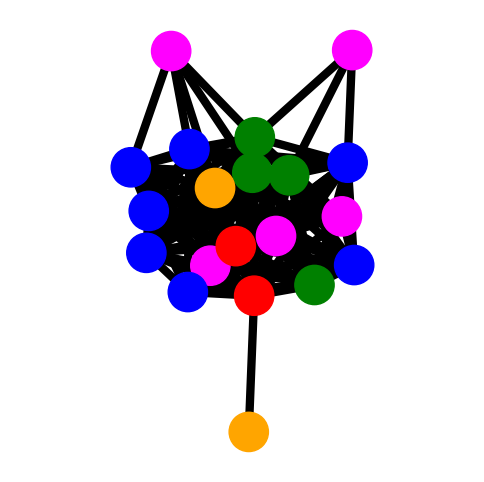

In [22]:
trainer[2].evaluate(threshold=0.5, show=True)

# Comp 4

In [33]:
cls_idx = 3
trainer[cls_idx] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=20,
        num_node_cls=len(dataset.NODE_CLS),
        temperature=0.15,
        learn_node_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=cls_idx, mode='maximize'), weight=1),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_idx]), weight=5),
        dict(key="logits", criterion=MeanPenalty(), weight=0),
        dict(key="omega", criterion=NormPenalty(order=1), weight=1),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=0),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=10, order=2, beta=1),
    target_probs={cls_idx: (0.9, 1)},
    k_samples=16
)

In [34]:
trainer[3].train(2000)

  0%|          | 0/2000 [00:00<?, ?it/s]

False

n=20 m=130
logits=[9.596939086914062, -3.480825424194336, -7.394070625305176, -8.979519844055176, -18.02598762512207]
probs=[0.9999978542327881, 2.091212081722915e-06, 4.177319823384096e-08, 8.557479169724047e-09, 1.0081251155050208e-12]


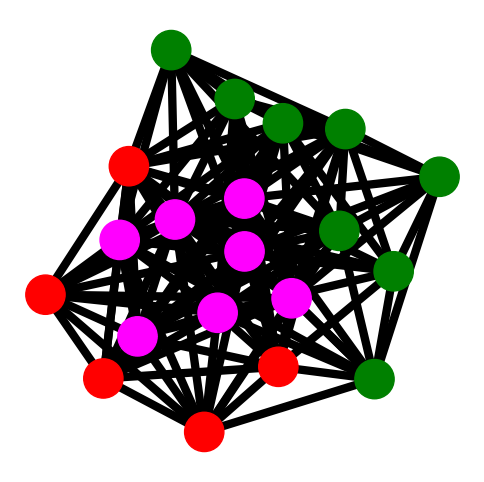

In [35]:
trainer[3].evaluate(threshold=0.5, show=True)

# Comp 5

In [36]:
cls_idx = 4
trainer[cls_idx] = Trainer(
    sampler=(s := GraphSampler(
        max_nodes=20,
        num_node_cls=len(dataset.NODE_CLS),
        temperature=0.15,
        learn_node_feat=True
    )),
    discriminator=model,
    criterion=WeightedCriterion([
        dict(key="logits", criterion=ClassScoreCriterion(class_idx=cls_idx, mode='maximize'), weight=1),
        dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_idx]), weight=5),
        dict(key="logits", criterion=MeanPenalty(), weight=0),
        dict(key="omega", criterion=NormPenalty(order=1), weight=1),
        dict(key="omega", criterion=NormPenalty(order=2), weight=1),
        dict(key="xi", criterion=NormPenalty(order=1), weight=0),
        dict(key="xi", criterion=NormPenalty(order=2), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
        # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
        dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=0),
    ]),
    optimizer=(o := torch.optim.SGD(s.parameters(), lr=1)),
    scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
    dataset=dataset,
    budget_penalty=BudgetPenalty(budget=10, order=2, beta=1),
    target_probs={cls_idx: (0.9, 1)},
    k_samples=16
)

In [37]:
trainer[4].train(5000)

  0%|          | 0/5000 [00:00<?, ?it/s]

False

n=20 m=107
logits=[27.466341018676758, -70.51366424560547, -0.8505165576934814, -57.5257682800293, 36.179771423339844]
probs=[0.00016433642304036766, 0.0, 8.277106698895517e-17, 2.0143665424669245e-41, 0.9998356103897095]


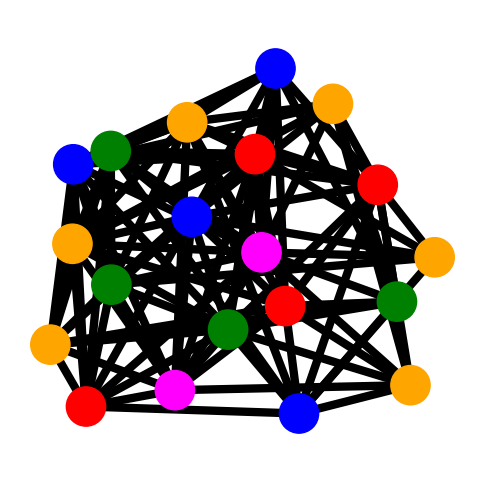

In [38]:
trainer[4].evaluate(threshold=0.5, show=True)